# Report of NLP problem for Frank
Given a set of posts, we've got two tasks:
1. Determine the attributes of a successful post on r/askscience
2. Build a model that can predict the score of a post on r/askscience given at least the title and body of the post (There is no need to limit it to just the title and body, but you must explain why you chose the features you did).

In [3]:
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import seaborn as sns
import lightgbm as lgb
from sklearn.metrics import r2_score
from gensim.utils import simple_preprocess
from gensim import corpora
from gensim.models import LdaModel
from transformers import BertTokenizer, BertModel
import torch

## Data Overview and Preprocessing

In [4]:
file = r'C:\Users\yu\Downloads\askscience_data.txt'

df = pd.read_csv(file)
total_samples = len(df)
print(f'Total samples: {total_samples}')

Total samples: 4205


In [7]:
# Correlation between score and upvote ratio
corr, p_value = pearsonr(df['score'], df['upvote_ratio'])
print('Correlation coefficient between score and upvote ratio is {} (p={})'.format(corr, p_value))

Correlation coefficient between score and upvote ratio is 0.5483241172951062 (p=0.0)


There are 33 tags.
Samples group by tag:
Biology                        724
Physics                        628
Human Body                     458
Medicine                       336
Earth Sciences                 318
Astronomy                      272
Chemistry                      229
COVID-19                       218
nan                            194
Engineering                    190
Planetary Sci.                 111
Neuroscience                   107
Mathematics                    102
Psychology                      90
Computing                       58
Paleontology                    47
Linguistics                     34
Anthropology                    23
Social Science                  20
Archaeology                     15
Economics                       14
Interdisciplinary                3
Earth Sciences and Biology       2
  Linguistics                    2
Ecology                          2
First image of a black hole      1
Dog Cognition AMA                1
Political Scie

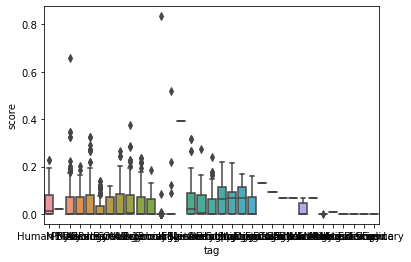

In [27]:
# Explore tags

df.loc[:, 'tag'] = df['tag'].replace(np.nan, 'nan')
print('There are {} tags.'.format(len(df['tag'].unique())))
# Boxplot group by tag (Sorry about the xticks. It would be easier to view if the ticks are rotated)
sns.boxplot(x='tag', y='score', data=df)

tag2count = df['tag'].value_counts()
print('Samples group by tag:')
print(tag2count)

# Create tag id
tag2index = dict((v, k) for k, v in enumerate(tag2count.index))
df.loc[:, 'tag_index'] = df['tag'].apply(lambda s: tag2index[s])

In [8]:
# Create column for length of title
df.loc[:, 'title_len'] = df['title'].apply(lambda s: len(s))

# Create column for length of body
df.loc[:, 'body_len'] = df['body'].apply(lambda s: len(s) if isinstance(s, str) else 0)

In [9]:
# Scale the score to [0, 1]
print('Maximum score before scaling: {}'.format(max(df['score'])))
df['score'] = df['score'] / 1e5
print('Maximum score after scaling: {}'.format(max(df['score'])))

Maximum score before scaling: 83382.0
Maximum score after scaling: 0.83382


**Remark**
1. "score" and "upvote ratio" are significantly correlated, indicating that upvote_ratio could be an important attribute of a successful post.
2. Tag is a potential attribute of interest and we will try including them as a feature in the prediction model. To get more detailed topics, below we also use LDA model to extract topics of each post, and then add them to the prediction model as well.

## Topic Model

In [10]:
titles = [simple_preprocess(s, deacc=True) if isinstance(s, str) else [] for s in df['title']]
bodies = [simple_preprocess(s, deacc=True) if isinstance(s, str) else [] for s in df['body']]
all_texts = titles + bodies
my_dictionary = corpora.Dictionary(all_texts)
doc_bow = [my_dictionary.doc2bow(t) for t in all_texts]

In [12]:
num_topics = 100  
print(f'Assume there are {num_topics} topics.')
LDA_model = LdaModel(corpus=doc_bow, num_topics=num_topics)
print('The LDA model is trained.')

Assume there are 100 topics.


C:\Users\yu\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\models\ldamodel.py:775: RuntimeWarning: divide by zero encountered in log
  diff = np.log(self.expElogbeta)


The LDA model is trained.


In [16]:
# Get topics from LDA model for each title and body

def doc2topic(s, dictionary, lda_model, num_topics):
    '''
    Transform a string to a vector of length num_topics, where each non-zero value is the weight of the corresponding topic
    '''
    bow = dictionary.doc2bow(s)
    topics = lda_model[bow]
    topic_fea = [0] * num_topics 
    for topic in topics:
        topic_fea[topic[0]] = topic[1]
    return topic_fea

title_lda = [doc2topic(t, my_dictionary, LDA_model, num_topics) for t in titles]
title_lda_names = ['title_lda_{}'.format(i) for i in range(num_topics)]
title_lda = pd.DataFrame(title_lda, columns=title_lda_names)

body_lda = [doc2topic(t, my_dictionary, LDA_model, num_topics) for t in bodies]
body_lda_names = ['body_lda_{}'.format(i) for i in range(num_topics)]
body_lda = pd.DataFrame(body_lda, columns=body_lda_names)

print('Created topic features for titles and bodies')

Created topic features for titles and bodies


## Text Embeddings with BERT
Topics extracted from the posts may not be sufficient to predict the score. Now we try to encode the posts into embeddings with the BERT model. We will study the effectiveness of both the topic features and text embeddings in the prediction model. 

In [18]:
# Load the BERT model
emb_size = 768
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Load the BERT model')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

Load the BERT model


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [19]:
# Encode titles and bodies into embeddings

def get_bert_embedding(s, tokenizer, model, emb_size):
    if not isinstance(s, str): # s is nan
        return [0] * emb_size
    else:
        s = tokenizer(s[:tokenizer.model_max_length], return_tensors="pt")
        outputs = model(**s)
        return torch.mean(torch.squeeze(outputs.last_hidden_state), dim=0).cpu().numpy().tolist()

print('Get title embeddings')
title_bert_emb = []
with torch.no_grad():
    for i, s in enumerate(df['title'], start=1):
        if i % 500 == 0:
            print('processing {}/{}'.format(i, total_samples))
        title_bert_emb.append(get_bert_embedding(s, tokenizer, model, emb_size))
title_bert_emb_names = ['title_bert_emb_{}'.format(i) for i in range(emb_size)]
title_bert_emb = pd.DataFrame(title_bert_emb, columns=title_bert_emb_names)

print('Get body embeddings')
body_bert_emb = []
with torch.no_grad():
    for i, s in enumerate(df['body'], start=1):
        if i % 500 == 0:
            print('processing {}/{}'.format(i, total_samples))
        body_bert_emb.append(get_bert_embedding(s, tokenizer, model, emb_size))
body_bert_emb_names = ['body_bert_emb_{}'.format(i) for i in range(emb_size)]
body_bert_emb = pd.DataFrame(body_bert_emb, columns=body_bert_emb_names)


Get title embeddings
processing 500/4205
processing 1000/4205
processing 1500/4205
processing 2000/4205
processing 2500/4205
processing 3000/4205
processing 3500/4205
processing 4000/4205
Get body embeddings
processing 500/4205
processing 1000/4205
processing 1500/4205
processing 2000/4205
processing 2500/4205
processing 3000/4205
processing 3500/4205
processing 4000/4205


In [20]:
# Merge all features together
df = pd.concat([df, title_lda, body_lda, title_bert_emb, body_bert_emb], axis=1)

## Prediction Model

In [40]:
# Set the features
basic_features = [
    'tag_index',
    'title_len',
    'body_len',   
    'upvote_ratio'
]
feature_setting = 3
if feature_setting == 0:
    features = basic_features
elif feature_setting == 1:
    features = basic_features + title_lda_names + body_lda_names
elif feature_setting == 2:
    features = basic_features + title_bert_emb_names + body_bert_emb_names
elif feature_setting == 3:
    features = basic_features + title_bert_emb_names + body_bert_emb_names + title_lda_names + body_lda_names
else:
    raise ValueError('Invalid value of feature_setting {}'.format(feature_setting))
categorical_feature = [i for i, f in enumerate(features) if f.endswith('_index')]
print(features)

['tag_index', 'title_len', 'body_len', 'upvote_ratio', 'title_bert_emb_0', 'title_bert_emb_1', 'title_bert_emb_2', 'title_bert_emb_3', 'title_bert_emb_4', 'title_bert_emb_5', 'title_bert_emb_6', 'title_bert_emb_7', 'title_bert_emb_8', 'title_bert_emb_9', 'title_bert_emb_10', 'title_bert_emb_11', 'title_bert_emb_12', 'title_bert_emb_13', 'title_bert_emb_14', 'title_bert_emb_15', 'title_bert_emb_16', 'title_bert_emb_17', 'title_bert_emb_18', 'title_bert_emb_19', 'title_bert_emb_20', 'title_bert_emb_21', 'title_bert_emb_22', 'title_bert_emb_23', 'title_bert_emb_24', 'title_bert_emb_25', 'title_bert_emb_26', 'title_bert_emb_27', 'title_bert_emb_28', 'title_bert_emb_29', 'title_bert_emb_30', 'title_bert_emb_31', 'title_bert_emb_32', 'title_bert_emb_33', 'title_bert_emb_34', 'title_bert_emb_35', 'title_bert_emb_36', 'title_bert_emb_37', 'title_bert_emb_38', 'title_bert_emb_39', 'title_bert_emb_40', 'title_bert_emb_41', 'title_bert_emb_42', 'title_bert_emb_43', 'title_bert_emb_44', 'title_ber

In [41]:
# Split the samples (with fixed random seed for reproductivity and ablation study)
np.random.seed(0)
df['r'] = np.random.rand(total_samples)
X_train = df.loc[df['r'] < 0.8][features]
y_train = df.loc[df['r'] < 0.8]['score']
X_val = df.loc[(df['r'] >= 0.8) & (df['r'] < 0.9)][features]
y_val = df.loc[(df['r'] >= 0.8) & (df['r'] < 0.9)]['score']
X_test = df.loc[df['r'] >= 0.9][features]
y_test = df.loc[df['r'] >= 0.9]['score']

In [42]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_feature)
lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
            
print('Start training LightGBM...')
num_trees = 100
params = {
    'objective': 'regression',
    'verbose': 0
}
gbm = lgb.train(
        params,
        lgb_train,
        num_boost_round=num_trees,
        valid_sets=lgb_val,
        callbacks=[lgb.early_stopping(stopping_rounds=5)]
    )
feature_importance = sorted(
    zip(features, gbm.feature_importance(importance_type='split')), 
    key=lambda t: t[1],
    reverse=True
)
print('Top 10 most important features (ranked by number of splitting):')
print(feature_importance[:10])

Start training LightGBM...


C:\Users\yu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\yu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:2068: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [0]
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.133263 seconds.
You can set `force_col_wise=true` to remove the overhead.


C:\Users\yu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\yu\AppData\Local\Continuum\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 0.000566866
Top 10 most important features (ranked by number of splitting):
[('upvote_ratio', 153), ('title_bert_emb_110', 74), ('body_bert_emb_132', 63), ('body_bert_emb_295', 26), ('body_bert_emb_715', 25), ('title_bert_emb_409', 20), ('tag_index', 16), ('title_len', 15), ('title_bert_emb_279', 14), ('title_bert_emb_344', 14)]


In [43]:
# Evaluate the model
print('Start evaluation...')
y_pred = gbm.predict(X_train, num_iteration=gbm.best_iteration)
r2 = r2_score(y_train, y_pred)
print('R2 of training dataset: {}'.format(r2))
y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
r2 = r2_score(y_val, y_pred)
print('R2 of validation dataset: {}'.format(r2))
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
r2 = r2_score(y_test, y_pred)
print('R2 of test dataset: {}'.format(r2))

Start evaluation...
R2 of training dataset: 0.9588251100469344
R2 of validation dataset: 0.7456521718704103
R2 of test dataset: 0.6223861579074297


**Ablation study (different choices of features and R2 of the test samples):**
1. basic features: R2 = 0.422
2. basic features + LDA topic features: R2 = 0.437
3. basic features + BERT embeddings: R2 = 0.599
4. basic features + LDA topic features + BERT embeddings: R2 = 0.622

# Conclusion
1. "upvote_ratio" is the most important attribute, which can be seen from the correlation analysis and feature importance of the LightGBM model. Besides, length of titles and bodies, tags are all considered basic features for predicting the score, though the performance is not as good as advanced features are used.
2. The ablation study shows that both topic features and BERT embeddings can improve the performance. The combinition of them produced the best model (R2=0.622)

## Future Work
1. It's  not clear that duplicated posts would have lower scores. This can be a potential feature to check out in the prediction model.
2. The correlation analysis and feature importance showed us general explanations for the post scores, which describes the patterns of the entire training set. However, sometimes people want to find explanation for a single case, which is also called responsibility in some studies. In that case, one can use Shapley values to calculate feature importance for each sample. Due to the deadline, this is not illustrated in the experiment above.